In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv("../data/input/train.csv")

df.shape

# drop bankruptcy_label and company_id in our feature dataset
feature_cols = [col for col in df.columns if col not in ("bankruptcy_label", "company_id")]

X = df[feature_cols]
X.shape

(9792, 64)

## Table of content

1. [Methodology](#methodology)
2. [Feature engineering](#feature-engineering)
    1. [Missing data](#missing-data)
    2. [Reverse_engineer](#reverse-engineer)
3. [Error analysis](#error-analysis)

## Methodology <a id="methodology"></a>

Concerning the practical methodology that we are following, we can say that:
* We have a working end-to-end pipeline.
* Our current model can work as a baseline model.
* We can monitor the system's performance by the learning curves.

As a consequence, we are only missing the last step of the practical methodology: to decide what to do next to improve the pipeline. Keeping in mind that our model is **underfitting**, we can improve the model in the following ways:

1. Perform feature engineering 
    * Improve the way we deal with the missing data. We decided to replace missing data with 0, but now it may be the time to search for a better imputation strategy.
    * Improve the existing features. We may explore the data to understand which features have the most influence on our model and if there is a way to boost them.
    * Build new features. Create new features that can increase the predictive power of the model.
    * Collect a different set of features.
    * Add polynomial/interaction terms.
2. Reduce regularization
3. Try a low bias algorithm
    * Support vector machine (non-linear kernels)
    * Tree-based algorithm
    * Ensemble models (bagging, boosting)

We will focus on feature engineering in this notebook. 

## Feature engineering <a id="feature-engineering"></a>

In the book [_How Google Works_](https://amzn.to/2M9hvv7), Eric Schmidt and Jonathan Rosenberg infer that Google's secret sauce is &#x201c;technical insight.&#x201d; According to the authors, it is fundamental technical insight that allows companies to create great products, which provide real value to the customers. For example, [PageRank](http://www.cs.princeton.edu/~chazelle/courses/BIB/pagerank.htm) gave an incredible competitive advantage to Google in relation to other search engines because it provided a far better way to rank search results on the web.

**Feature extraction** is our technological insight in machine learning. It addresses the problem of attaining the most informative and compact set of features to improve the performance of machine learning models. In this context, &#x201c;informative&#x201d; means that we are looking for features that can characterize the behavior of what we are trying to model. For instance, if we want to create a model for weather forecast, features like temperature, humidity, and wind are informative (they are related to the problem). By contrast, the result of a football game will not be an informative feature because it doesn't affect the weather (as far as we know).

By &#x201c;compact,&#x201d; what is meant is we should exclude features that are irrelevant for the model. There are several reasons to exclude irrelevant features. In our case, I'd say that the most important reason is to reduce overfitting. Consider the weather example: we know that the result of a football game doesn't affect the weather, but suppose that all rain instances in our training set happen to occur after a Manchester United victory. Then, our model might learn that rain is related to Manchester United's victories, which is not true. Such an incorrect generalization from an irrelevant feature would result in a machine learning model that fits a particular set of data, but fails to predict future observations reliably (overfitting).

In the following sub-sections, we address these two issues by performing:
1. **Feature engineering**, which is related to the generation of informative features.
2. **Feature selection**, which regards the choice of a compact set of features.

### Missing data <a id="missing-data"></a>

Just a recap, from our exploratory data analysis, we observe that most of the columns have **low proportion of missing values**, with the exception of *(current assets - inventories) / long-term liabilities* (#36), which has 4442 missing values. 

Using our domain knowledge, an obvious reason why we have missing values for this column is that the firm has no long-term liabilities (so the denominator is zero).

There are two columns which use long-term liabilities in the formula:
1. (current assets - inventories) / long-term liabilities
2. long-term liabilities / equity

If our hypothesis is correct, we should expect companies which have missing values for the first column, also have zero values for the second column.  

In [3]:
col1 = '(current assets - inventories) / long-term liabilities'
col2 = 'long-term liabilities / equity'

X.loc[X[col1].isna(), col2].all() == 0

True

Bingo! So this feature is not missing completely at random. The fact that it is missing tells us an important piece of information: The company has no long-term liabilities.

How does this inform us on how to deal with this missing feature?

Well, leveraging our domain knowledge, this ratio is another variation of liquidity ratio, which determines if a company can use its liquid assets to cover its long-term debt obligations. If the ratio is large, then it indicates that the company is able to cover its liabilities and hence the default risk is lower. 

Therefore, we should expect bankrupt companies to have a lower ratio of *(current assets - inventories) / long-term liabilities*. We can use a boxplot to verify this relationship:

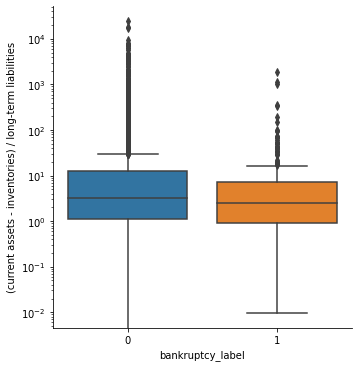

In [4]:
g = sns.catplot(data=df, x="bankruptcy_label", y='(current assets - inventories) / long-term liabilities', kind="box")
g.ax.set_yscale('log')

If the company has no long-term liabilities, then it should have a high ratio of *(current assets - inventories) / long-term liabilities* to indicate its strong ability to cover the long-term debt (if it exists). 

Therefore, we should fill in the missing values with the maximum value, instead of zero like what we did previously.

In [5]:
col = '(current assets - inventories) / long-term liabilities' 
X[col].fillna(X[col].max(), inplace=True)

C:\Users\kwj_9\Anaconda3\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


We could have look at each column and use a similar strategy to impute the missing values.

However, given that the other columns have **low proportion of missing values**, the impact of filling these missing values with the correct ones will be quite limited. Therefore, we will employ the same strategy as before: filling them with zeros. 

Before we fill the null values, we will also discard the companies which have more than 10 missing values. It turns out that there are 47 companies which have more than 10 missing values, of which 3 of them belongs to the minority class.

This corresponds to removing 0.7% (3/412) of the samples in minority class, which is quite reasonable. 

In [6]:
# rows with more than 10 missing values
more_than_10_missing = df[df.isnull().sum(axis=1) > 10]
print(f"There are {len(more_than_10_missing)} rows with more than 10 missing values")

more_than_10_missing["bankruptcy_label"].value_counts()

There are 47 rows with more than 10 missing values


0    44
1     3
Name: bankruptcy_label, dtype: int64

### Reverse engineer <a id="reverse-engineer"></a>

Another important feature we could generate is whether the company has any liability at all.

By definition, If the company has no liability, then it couldn't possibly go bankrupt.   

However, in order to do this, we have to reverse engineer the *total liabilities* from the financial ratios. Fortunately, we could do so with the help of these two columns:
1. logarithm of total assets
2. total liabilities / total assets

By taking the exponential of the first column and multiplying with the second column, we can get the *total liabilities*.

Well, if we can do this for *total liabilities*, why can't we do this for the other *raw values*? From here I will use *ratio* to refer to the original financial ratios we were given in the dataset, and use *raw* values to refer to the values we reverser engineer from the *ratio*. 

> The main benefit of having these *raw* values is that we are not locked into the financial ratios given in the dataset. Instead, we can now generate new ratios/features ourselves.

There are 33 *raw* values which we manage to derive from the 64 financial ratios. 

I will not go into details on how we reverse engineer these raw values as there is nothing fancy here, just simple mathematics. However, if you are interested in how we derive these *raw* values, you can look at the code [here](https://github.com/waijean/company_default/tree/master/data_engineering/reverse_engineer).

Let's go ahead and load the combined dataset of both *raw* and *ratio*.

In [7]:
combined_df = pd.read_csv("../data/output/combined_train.csv")

# drop bankruptcy_label and company_id in our feature dataset
feature_cols = [col for col in combined_df.columns if col not in ("BANKRUPTCY_LABEL", "company_id")]

combined_X = combined_df[feature_cols]
combined_X.shape

(9664, 97)

As expected, the number of columns increase from 64 to 97 (64+33) as expected.

You might also notice that there is a reduction of 128 rows (from 9792 to 9664). This is because we also remove duplicates and remove companies with more than 10 null values in the reverse engineering pipeline. 

Now that we have the total liabilities, let's look at the companies which have zero liabilities. 

In [8]:
zero_total_liabilities_df = combined_df.loc[round(combined_df["TOTAL_LIABILITIES"]) == 0, ["TOTAL_LIABILITIES", "BANKRUPTCY_LABEL"]]
print(f"There are {len(zero_total_liabilities_df)} companies which have zero liability.")
zero_total_liabilities_df

There are 14 companies which have zero liability.


,TOTAL_LIABILITIES,BANKRUPTCY_LABEL
1284,0.45,0
1834,0.32,0
2013,0.40,0
2427,0.40,0
2845,0.17,0
4026,0.04,0
4296,0.23,0
4722,0.46,0
4736,0.06,0
4749,0.32,0


The observation is in line with our hypothesis: all the companies which have zero liability did not go bankrupt eventually.

However, the bad news is there are only 14 companies which have zero liability, out of a total of 9710 companies. If we were to create a dummy column which indicates whether the company has zero liability, only 14 rows of that column will be 1. The rest will be 0. 

Worse still, if we use undersampling, then we will discard some of these rows as well since they belong to the majority class.

Therefore, we will not proceed with generating this feature.

### Additional feature engineering techniques

There are additional feature engineering techniques such as:
* Box-Cox transformations [(Box & Cox 1964)](https://www.nuffield.ox.ac.uk/users/cox/cox72.pdf);
* Polynomials generation through non-linear expansions.

#### Box-Cox transformations

Box-Cox transformations aim to normalize the features. These transformations are an alternative to conventional transformations such as the square root transformation, log transformation, and inverse transformation. The main advantage of the Box-Cox transformations is that they optimally normalize the chosen feature. Thus, they avoid the need to randomly try different transformations, automating the data transformation process.

#### Polynomials

We can enrich our set of features by generating polynomials. Polynomial expansion creates interactions between features, as well as creates powers (e.g., the square of a feature). This way, we introduce a nonlinear dimension to the data set, which can improve the predictive power of our model.

However, after applying these techniques, the model performance did not improve much so we will skip these techniques in this notebook. 

Note that up until this step, we have not changed the pipeline component. Everything in the pipeline remains the same so we can reuse the pipeline in the last notebook.

All we have changed is the data we are passing into the pipeline. 

Let's see how our pipeline performs with the additional *raw* features we have generated. 

Metrics: 
test_precision   0.20
test_recall      0.75
test_fbeta       0.48
dtype: float64


C:\Users\kwj_9\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\kwj_9\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

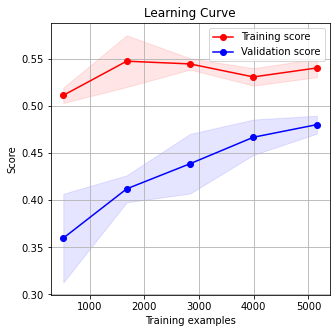

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from diagnosis import plot_learning_curve

def evaluate_pipeline(pipeline, X_train, y_train, cv):
    """
    Run cross validation for the input pipeline and returns the average precision, recall and F-beta score.
    """
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=cv, scoring={"precision":"precision", "recall":"recall", "fbeta":make_scorer(fbeta_score, beta=2)})
    cv_metrics_df = pd.DataFrame(cv_metrics)
    average_cv_metrics = cv_metrics_df[["test_precision", "test_recall", "test_fbeta"]].mean()
    return average_cv_metrics


# drop bankruptcy_label and company_id in our feature dataset
feature_cols = [col for col in combined_df.columns if col not in ("BANKRUPTCY_LABEL", "company_id")]
X = combined_df[feature_cols]
y = combined_df["BANKRUPTCY_LABEL"]

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
stratified_cv = StratifiedKFold(n_splits=3)

# pipeline components
rus = RandomUnderSampler(random_state=0)
scaler = RobustScaler()
classifier = LogisticRegression(random_state=0, solver="newton-cg", max_iter=200)

pipeline = Pipeline([('rus', rus), ('scaler', scaler),  ("classifier", classifier)])
metrics = evaluate_pipeline(pipeline, X_train, y_train, stratified_cv)
print(f"Metrics: \n{metrics}")

plot_learning_curve(pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2))

Our feature engineering work has successfully improved the F-beta score from the baseline of 0.36 to 0.48. 

Plotting the learning curve shows that we are still underfitting so we will try low-bias algorithm in the next notebook. 

## Summary

As [Halevy et al. (2009)](https://static.googleusercontent.com/media/research.google.com/pt-PT//pubs/archive/35179.pdf) noted &#x201c;invariably, simple models and a lot of data trump more elaborate models based on less data.&#x201d; [Monica Rogati](https://youtu.be/F7iopLnhDik) added that &#x201c;better data beats more data.&#x201d; 

Based on these principles, the aim of this notebook is to improve data quality through feature engineering. We didn't use a clever algorithm, but we explored clever techniques to make our data better.

## References

**Books**

* [Ries, E., 2011. The Lean Startup: How Today's Entrepreneurs Use Continuous Innovation to Create Radically Successful Businesses](https://amzn.to/2JsIMH3)
* [Hair, J.F., Black, W.C., Babin, B.J., Anderson, R.E. and Tatham, R.L., 2013. Multivariate data analysis](https://amzn.to/2JtC1Vm)
* [Asefeso, A., Lund, S.B., Parry, H., 2014. Keep Your Eyes On the Horizon: Business Lessons from Unsinkable Titanic](https://amzn.to/2JwpsIT)

**Papers**

* [Heaton, J., 2016. An empirical analysis of feature engineering for predictive modeling. In SoutheastCon, 2016 (pp. 1-6). IEEE.](https://arxiv.org/pdf/1701.07852.pdf)
* [Box, G.E. and Cox, D.R., 1964. An analysis of transformations. Journal of the Royal Statistical Society. Series B (Methodological), pp.211-252.](https://www.nuffield.ox.ac.uk/users/cox/cox72.pdf)
* [Guyon, I. and Elisseeff, A., 2003. An introduction to variable and feature selection. Journal of machine learning research, 3(Mar), pp.1157-1182.](http://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf)
* [Halevy, A., Norvig, P. and Pereira, F., 2009. The unreasonable effectiveness of data. IEEE Intelligent Systems, 24(2), pp.8-12.](https://static.googleusercontent.com/media/research.google.com/pt-PT//pubs/archive/35179.pdf)

**Videos**

* [Rogati, M., 2012. The Model and the Train Wreck: A Training Data How-To. O'Reilly Strata.](https://youtu.be/F7iopLnhDik)
* [Kleon, A., 2012. Steal like an artist. TEDx Talks.](https://youtu.be/oww7oB9rjgw)
